In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/silk-dataset/silk_dataset/IMG_3946.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2771.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3912.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3167.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2760.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2844.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2765.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2711.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3114.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2740.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3538.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2791.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3095.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3520.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2987.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3809.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3030.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3925.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_27

In [2]:
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from tqdm import tqdm # For progress bars
import cv2 # OpenCV for image loading
from PIL import Image # Pillow for image processing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision.models as models # For EfficientNetV2
import time 
from sklearn.preprocessing import StandardScaler
try:
    import timm # For MobileViT
    _timm_available = True
except ImportError:
    print("Warning: 'timm' library not found. MobileViT models will not be available. Please install it: pip install timm")
    _timm_available = False

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.cluster import MiniBatchKMeans # For unsupervised clustering
import seaborn as sns # For confusion matrix visualization
import torchvision.transforms as transforms
import requests # For downloading the checkpoint (if needed by SAM or other models)
import random # For random image selection (e.g., if not loading from CSV or for verification)
import matplotlib.colors as mcolors # NEW: For creating a custom colormap
import subprocess # Needed for git clone
import sys # Needed for sys.path.append
from pathlib import Path # For path manipulation
import matplotlib.patches as mpatches


In [3]:
# --- Add this block at the very top of your script, before get_classification_model is called ---
# Check and clone RepNeXt if not already present and register with timm
REPNEXT_VARIANT = "repnext_m1" # The specific RepNeXt model you want to use

# Check if the variant is already registered in timm
if REPNEXT_VARIANT not in timm.list_models("*repnext*"):
    repnext_repo_path = Path("RepNeXt") # Directory name after cloning
    
    if not repnext_repo_path.exists():
        print(f"Cloning RepNeXt repository for {REPNEXT_VARIANT}...")
        try:
            subprocess.run(["git", "clone", "--depth", "1", "https://github.com/suous/RepNeXt.git"], check=True)
            print("RepNeXt repository cloned successfully.")
        except subprocess.CalledProcessError as e:
            print(f"ERROR: Failed to clone RepNeXt repository: {e}")
            sys.exit("Cannot proceed without RepNeXt model.")
    
    # Add the cloned repository to Python's path
    if str(repnext_repo_path) not in sys.path:
        sys.path.append(str(repnext_repo_path))
        print(f"Added {repnext_repo_path} to sys.path.")

    # Import model.repnext to register RepNeXt variants with timm
    # This import needs to happen AFTER adding the path.
    try:
        import model.repnext # This module handles registration
        print(f"RepNeXt models registered with timm.")
    except ImportError as e:
        print(f"ERROR: Could not import model.repnext from {repnext_repo_path}. Ensure it's correctly cloned and structured.")
        sys.exit(f"Failed to register RepNeXt model {REPNEXT_VARIANT}.")
else:
    print(f"RepNeXt model '{REPNEXT_VARIANT}' already registered with timm.")

Cloning RepNeXt repository for repnext_m1...


Cloning into 'RepNeXt'...


RepNeXt repository cloned successfully.
Added RepNeXt to sys.path.
RepNeXt models registered with timm.


In [ ]:
# --- Configuration Constants ---
KAGGLE_DATA_PATH = '/kaggle/input/silk-dataset/' # Base path to your dataset on Kaggle.
CSV_FILE_NAME = '0_data.csv' # Name of the CSV file containing image metadata.
IMAGE_SIZE = (224, 224) # Standard input size (height, width) for pre-trained models like EfficientNet.
BATCH_SIZE = 32 # Number of samples processed in one forward/backward pass.
NUM_CLASSIFICATION_EPOCHS = 10 # Number of training epochs for the classification model.
NUM_SEGMENTATION_CLUSTERS = 3 # Number of classes for segmentation (e.g., Silkworms, Mulberry Leaves, Background).
BEST_CLASSIFICATION_MODEL_PATH = 'best_classification_model.pth' # File path to save the best performing classification model.

# Classification model type: Choose one.
# 'efficientnet_v2_s' is selected as per the last assignment in the original code.
CLASSIFICATION_MODEL_TYPE = 'efficientnet_v2_s' 
# Other possible options could be: 'mobilevit_s', or 'repnext_tiny'

# Control which feature layer to extract for segmentation.
# For EfficientNetV2, 'features' has 8 blocks (indexed 0 to 7).
# Layers 6 or 7 are typically good candidates as they capture higher-level spatial information.
FEATURE_EXTRACT_LAYER_INDEX = 6 

# Flag for Spatial Aware Clustering:
# If True, clustering will consider not only color but also pixel coordinates.
USE_SPATIAL_AWARE_CLUSTERING = True

# Flag for Attention Guided Clustering (e.g., CAM-Weighted Clustering).
# Currently noted as "not fully implemented for weighting KMeans" in the original comments,
# indicating it's a conceptual flag or work in progress.
USE_ATTENTION_GUIDED_CLUSTERING = True


# ImageNet normalization parameters (mean and standard deviation).
# These are standard values used for normalizing images pre-trained on ImageNet,
# which is common for transfer learning.
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Set device for PyTorch operations (GPU if available, otherwise CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Data Loading and Preprocessing ---
print("--- Starting Data Loading and Preprocessing ---")

# Construct the full path to the CSV file.
csv_file_path = os.path.join(KAGGLE_DATA_PATH, 'silk_dataset', CSV_FILE_NAME)
df = None # Initialize DataFrame as None.

try:
    df = pd.read_csv(csv_file_path) # Attempt to load the CSV file into a pandas DataFrame.
    print(f"Successfully loaded {csv_file_path}")
    print("DataFrame head (original column names):")
    print(df.head()) # Display the first few rows of the DataFrame with original column names.
    print("\nDataFrame info:")
    df.info() # Print a summary of the DataFrame (data types, non-null values).

    # Rename columns for consistency and easier access within the code.
    df = df.rename(columns={'foto': 'file_name', 'classificazione': 'label'})
    print("\nRenamed columns to 'file_name' and 'label'. DataFrame head (after rename):")
    print(df.head()) # Display DataFrame head after renaming.

    # Verify that the renaming was successful and the expected columns exist.
    if 'file_name' not in df.columns or 'label' not in df.columns:
        raise ValueError("Column renaming failed! 'file_name' or 'label' columns not found after rename operation.")

except FileNotFoundError:
    print(f"Error: {csv_file_path} not found. Please ensure the CSV file is in the specified path within your Kaggle dataset.")
    print("Exiting data loading. Please check your dataset path and file name.")
    exit() # Exit the script if the CSV file is not found.

# Set the root directory where the image files are located.
image_root_dir = os.path.join(KAGGLE_DATA_PATH, 'silk_dataset')
print(f"Image root directory set to: {image_root_dir}")

# Verify a sample image can be loaded and displayed.
if not df.empty: # Check if the DataFrame is not empty.
    sample_image_filename = df['file_name'].iloc[0] # Get the filename of the first image from the DataFrame.
    sample_image_path = os.path.join(image_root_dir, sample_image_filename) # Construct the full path to the sample image.

    try:
        sample_image = cv2.imread(sample_image_path) # Attempt to read the image using OpenCV (loads in BGR format).
        if sample_image is not None: # Check if the image was loaded successfully.
            sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB for matplotlib display.
            plt.figure(figsize=(6, 6)) # Create a figure for displaying the image.
            plt.imshow(sample_image_rgb) # Display the image.
            plt.title(f"Sample Image: {sample_image_filename}") # Set the title of the plot.
            plt.axis('off') # Turn off axes for a cleaner look.
            plt.show() # Show the plot.
            print(f"Sample image '{sample_image_filename}' loaded successfully from {sample_image_path}.")
        else:
            print(f"Warning: Could not read sample image at {sample_image_path}. Image data might be corrupted or not a valid image file.")
            print("Attempting to load a few more random images for verification...")
            # If the first sample fails, try loading a few more random images.
            for _ in range(3): # Try up to 3 more random images.
                random_idx = np.random.randint(0, len(df)) # Get a random index.
                rand_img_filename = df['file_name'].iloc[random_idx] # Get a random image filename.
                rand_img_path = os.path.join(image_root_dir, rand_img_filename) # Construct its full path.
                try:
                    rand_img = cv2.imread(rand_img_path) # Try to read the random image.
                    if rand_img is not None:
                        plt.figure(figsize=(4,4))
                        plt.imshow(cv2.cvtColor(rand_img, cv2.COLOR_BGR2RGB))
                        plt.title(f"Random Image: {rand_img_filename}")
                        plt.axis('off')
                        plt.show()
                        print(f"Random image '{rand_img_filename}' loaded successfully.")
                        break # Break the loop if a random image loads successfully.
                    else:
                        print(f"Failed to load random image {rand_img_filename}.")
                except Exception as e_rand:
                    print(f"Error loading random image {rand_img_filename}: {e_rand}")

    except Exception as e:
        print(f"An unexpected error occurred while loading sample image {sample_image_path}: {e}")
else:
    print("DataFrame is empty, skipping sample image display.")

class SilkwormDataset(torch.utils.data.Dataset):
    """
    A custom PyTorch Dataset class for loading silkworm images and their labels.
    """
    def __init__(self, dataframe: pd.DataFrame, root_dir: str, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): Pandas DataFrame containing image file names and labels.
            root_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.dataframe = dataframe # Store the DataFrame.
        self.root_dir = root_dir # Store the root directory of images.
        self.transform = transform # Store any image transformations.

    def __len__(self) -> int:
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.dataframe)

    def __getitem__(self, idx: int):
        """
        Retrieves an image and its corresponding label by index.

        Args:
            idx (int or torch.Tensor): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing the image tensor and the label tensor.
        """
        if torch.is_tensor(idx): # Convert PyTorch tensor index to a Python list/int if needed.
            idx = idx.tolist()

        # Construct the full path to the image file.
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]['file_name'])

        # Open the image using PIL and convert to RGB format.
        image = Image.open(img_name).convert('RGB')

        # Get the label from the DataFrame and convert it to a PyTorch float32 tensor.
        label = torch.tensor(self.dataframe.iloc[idx]['label'], dtype=torch.float32)

        if self.transform: # Apply transformations if any are defined.
            image = self.transform(image)

        return image, label # Return the transformed image and its label.

In [ ]:
# Data Augmentation and Normalization Transforms
# These transformations are applied to the images during loading.
train_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), # Resize images to a consistent size (e.g., 224x224).
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally for data augmentation.
    transforms.RandomRotation(10), # Randomly rotate images by up to 10 degrees.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Randomly adjust brightness, contrast, saturation, and hue.
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor (scales pixel values to [0, 1]).
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # Normalize pixel values using ImageNet's mean and std.
])

val_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), # Resize images to a consistent size.
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor.
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # Normalize pixel values.
])
print("Using torchvision for data transforms.")

# Create the full dataset instance.
full_dataset = SilkwormDataset(dataframe=df, root_dir=image_root_dir, transform=None)
print(f"Total dataset size: {len(full_dataset)} images.")

# Define the split ratios for training and validation.
train_size = int(0.8 * len(full_dataset)) # 80% of data for training.
val_size = len(full_dataset) - train_size # Remaining data for validation.
# Perform a random split of the dataset indices, ensuring reproducibility with a fixed generator seed.
train_dataset_indices, val_dataset_indices = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Create separate dataset instances for training and validation, applying their respective transforms.
# .iloc[...].copy() is used to prevent SettingWithCopyWarning by ensuring a new DataFrame is created for each split.
train_dataset = SilkwormDataset(dataframe=df.iloc[train_dataset_indices.indices].copy(),
                                 root_dir=image_root_dir,
                                 transform=train_transforms)
val_dataset = SilkwormDataset(dataframe=df.iloc[val_dataset_indices.indices].copy(),
                               root_dir=image_root_dir,
                               transform=val_transforms)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Create DataLoader instances for training and validation.
# DataLoader handles batching, shuffling, and multi-threaded data loading.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # Shuffle training data.
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) # Do not shuffle validation data.

print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")

print("\n--- Dataset Summary ---")
# Create a summary DataFrame for clarity.
dataset_summary = pd.DataFrame({
    'Metric': ['Total Images', 'Training Images', 'Validation Images', 'Training Batches', 'Validation Batches'],
    'Value': [len(full_dataset), len(train_dataset), len(val_dataset), len(train_loader), len(val_loader)]
})
print(dataset_summary.to_string(index=False)) # Print the summary without the DataFrame index.
print("\n--- Data Loading and Preprocessing Complete ---")

# --- Rearing Classification: Lightweight Architectures ---
print("\n--- Starting Rearing Classification Task ---")

def get_classification_model(model_type: str = 'efficientnet_v2_s', num_classes: int = 1, pretrained: bool = True):
    """
    Initializes and returns a pre-trained classification model based on the specified type.
    Supports EfficientNetV2-S, MobileViT-S (requires timm), and RepNext (requires timm).

    Args:
        model_type (str): The type of model to initialize ('efficientnet_v2_s', 'mobilevit_s', 'repnext_tiny').
        num_classes (int): The number of output classes for the final classification layer.
        pretrained (bool): If True, loads pre-trained weights (typically ImageNet).

    Returns:
        torch.nn.Module: The initialized classification model.
    Raises:
        ImportError: If 'timm' library is required but not found.
        ValueError: If an unknown model_type is specified.
    """
    model = None
    if model_type == 'efficientnet_v2_s':
        # Load EfficientNetV2-S. Use default weights if pretrained is True.
        model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT if pretrained else None)
        # Get the number of input features for the final classifier layer.
        num_ftrs = model.classifier[1].in_features
        # Replace the final classifier layer with a new one adapted for `num_classes`.
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        print(f"Initialized EfficientNetV2-S model (pretrained={pretrained}).")
    elif model_type == 'mobilevit_s':
        if not _timm_available: # Check if timm is installed.
            raise ImportError("timm library not found. Cannot load MobileViT-S. Please install it: pip install timm")
        # Create MobileViT-S model using timm.
        model = timm.create_model('mobilevit_s', pretrained=pretrained, num_classes=num_classes)
        print(f"Initialized MobileViT-S model via timm (pretrained={pretrained}).")
    elif model_type == REPNEXT_VARIANT: # Use the global REPNEXT_VARIANT parameter for RepNext.
        if not _timm_available: # Check if timm is installed.
            raise ImportError("timm library not found. Cannot load RepNext. Please install it: pip install timm")
        # timm.create_model will recognize REPNEXT_VARIANT (e.g., 'repnext_tiny').
        # Note: 'pretrained=False' is often set for custom RepNext variants unless specific weights are available.
        model = timm.create_model(REPNEXT_VARIANT, pretrained=False, num_classes=num_classes)
        print(f"Initialized {REPNEXT_VARIANT} model via timm (pretrained={pretrained}).")
    else:
        raise ValueError(f"Unknown model_type: {model_type}. Choose 'efficientnet_v2_s', 'mobilevit_s', or '{REPNEXT_VARIANT}'.")

    return model
    
# Initialize the classification model based on the global CLASSIFICATION_MODEL_TYPE.
classification_model = get_classification_model(
    model_type=CLASSIFICATION_MODEL_TYPE,
    num_classes=1, # 1 output neuron for binary classification (e.g., 'silkworm present' vs 'absent').
    pretrained=True # Use ImageNet pre-trained weights.
)
classification_model.to(device) # Move the model to the specified device (GPU/CPU).
print(f"{CLASSIFICATION_MODEL_TYPE} classification model initialized and moved to device.")

# Define the loss function for binary classification.
# BCEWithLogitsLoss combines sigmoid activation and binary cross-entropy loss, which is numerically more stable.
classification_criterion = nn.BCEWithLogitsLoss()
# Define the optimizer (Adam) for updating model weights.
classification_optimizer = optim.Adam(classification_model.parameters(), lr=0.001)

def train_classification_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                               criterion: nn.Module, optimizer: optim.Optimizer, num_epochs: int,
                               device: torch.device, model_save_path: str) -> tuple:
    """
    Trains the classification model, evaluates it on the validation set,
    and tracks various performance metrics. Saves the best model based on validation accuracy.

    Args:
        model (nn.Module): The classification model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (nn.Module): The loss function.
        optimizer (optim.Optimizer): The optimizer.
        num_epochs (int): Number of training epochs.
        device (torch.device): The device (CPU or GPU) to run training on.
        model_save_path (str): Path to save the best performing model.

    Returns:
        tuple:
            - history (dict): Dictionary containing training and validation metrics for each epoch.
            - all_val_labels (np.ndarray): All true labels from the validation set.
            - val_preds_binary (np.ndarray): All binary predictions from the validation set.
            - all_val_preds (np.ndarray): All raw prediction probabilities from the validation set.
    """
    best_val_accuracy = 0.0 # Initialize the best validation accuracy.
    history = { # Dictionary to store training and validation metrics over epochs.
        'train_loss': [], 'train_acc': [], 'train_f1': [], 'train_precision': [], 'train_recall': [], 'train_roc_auc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_precision': [], 'val_recall': [], 'val_roc_auc': []
    }
    print(f"Training classification model for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train() # Set the model to training mode.
        running_loss = 0.0
        all_train_preds = [] # List to collect all predictions (probabilities) for metric calculation.
        all_train_labels = [] # List to collect all true labels.

        print(f"Epoch {epoch+1}/{num_epochs} (Training Phase)")
        for images, labels in tqdm(train_loader, desc="Training Batches"): # Iterate through training batches with a progress bar.
            images = images.to(device) # Move images to the specified device.
            labels = labels.to(device).view(-1, 1) # Move labels to device and reshape for BCEWithLogitsLoss.

            optimizer.zero_grad() # Clear previous gradients.
            outputs = model(images) # Forward pass: get model outputs (logits).
            loss = criterion(outputs, labels) # Calculate the loss.
            loss.backward() # Backward pass: compute gradients.
            optimizer.step() # Update model weights.

            running_loss += loss.item() * images.size(0) # Accumulate running loss.
            probabilities = torch.sigmoid(outputs).cpu().detach().numpy() # Convert logits to probabilities, move to CPU, detach, convert to NumPy.
            all_train_preds.extend(probabilities) # Add probabilities to list.
            all_train_labels.extend(labels.cpu().detach().numpy()) # Add true labels to list.

        epoch_train_loss = running_loss / len(train_loader.dataset) # Calculate average training loss for the epoch.
        train_preds_binary = (np.array(all_train_preds) > 0.5).astype(int) # Convert probabilities to binary predictions (0 or 1).
        train_accuracy = accuracy_score(all_train_labels, train_preds_binary) # Calculate accuracy.
        train_f1 = f1_score(all_train_labels, train_preds_binary, zero_division=0) # Calculate F1-score.
        train_precision = precision_score(all_train_labels, train_preds_binary, zero_division=0) # Calculate precision.
        train_recall = recall_score(all_train_labels, train_preds_binary, zero_division=0) # Calculate recall.
        train_roc_auc = roc_auc_score(all_train_labels, np.array(all_train_preds)) # Calculate ROC AUC.

        # Store training metrics in history.
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(train_accuracy)
        history['train_f1'].append(train_f1)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_roc_auc'].append(train_roc_auc)

        print(f"Train Loss: {epoch_train_loss:.4f}, Acc: {train_accuracy:.4f}, F1: {train_f1:.4f}, Prec: {train_precision:.4f}, Rec: {train_recall:.4f}, ROC AUC: {train_roc_auc:.4f}")

        # --- Validation Phase ---
        model.eval() # Set the model to evaluation mode.
        val_running_loss = 0.0
        all_val_preds = [] # List to collect all validation predictions (probabilities).
        all_val_labels = [] # List to collect all true validation labels.

        print(f"Epoch {epoch+1}/{num_epochs} (Validation Phase)")
        with torch.no_grad(): # Disable gradient calculations during validation.
            for images, labels in tqdm(val_loader, desc="Validation Batches"):
                images = images.to(device)
                labels = labels.to(device).view(-1, 1)

                outputs = model(images) # Forward pass.
                loss = criterion(outputs, labels) # Calculate loss.

                val_running_loss += loss.item() * images.size(0)
                probabilities = torch.sigmoid(outputs).cpu().detach().numpy()
                all_val_preds.extend(probabilities)
                all_val_labels.extend(labels.cpu().detach().numpy())

        epoch_val_loss = val_running_loss / len(val_loader.dataset) # Calculate average validation loss.
        val_preds_binary = (np.array(all_val_preds) > 0.5).astype(int) # Convert probabilities to binary predictions.
        val_accuracy = accuracy_score(all_val_labels, val_preds_binary) # Calculate validation accuracy.
        val_f1 = f1_score(all_val_labels, val_preds_binary, zero_division=0)
        val_precision = precision_score(all_val_labels, val_preds_binary, zero_division=0)
        val_recall = recall_score(all_val_labels, val_preds_binary, zero_division=0)
        val_roc_auc = roc_auc_score(all_val_labels, np.array(all_val_preds))

        # Store validation metrics in history.
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(val_accuracy)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_roc_auc'].append(val_roc_auc)

        print(f"Val Loss: {epoch_val_loss:.4f}, Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}, Prec: {val_precision:.4f}, Rec: {val_recall:.4f}, ROC AUC: {val_roc_auc:.4f}")

        # Save the model if current validation accuracy is better than the best recorded.
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path) # Save only the model's state dictionary.
            print(f"Saved best model with Val Accuracy: {best_val_accuracy:.4f} to {model_save_path}")

    print("--- Classification Training Complete ---")
    return history, np.array(all_val_labels), val_preds_binary, np.array(all_val_preds)

# --- GradCAM Class Definition (Defined Once) ---
class GradCAM:
    """
    Implements Grad-CAM to visualize activation maps for a given class in a PyTorch model.
    Adapted for a binary classification model (single output logit).
    """
    def __init__(self, model: nn.Module, target_layer_name: str):
        """
        Initializes the GradCAM object.

        Args:
            model (nn.Module): The PyTorch model.
            target_layer_name (str): The name of the target convolutional layer
                                     from which to extract activations and gradients.
        """
        self.model = model
        self.model.eval()   # Ensure the model is in evaluation mode.
        self.target_layer_name = target_layer_name
        self.activations = None # Stores the forward activations of the target layer.
        self.gradients = None # Stores the backward gradients of the target layer.

        # Find the target layer by iterating through named modules.
        self.target_layer = None
        for name, module in self.model.named_modules():
            if name == self.target_layer_name:
                self.target_layer = module
                break

        if self.target_layer is None:
            raise ValueError(f"Target layer '{target_layer_name}' not found in model.")

        # Clear any existing hooks to prevent conflicts if this class is re-instantiated.
        if hasattr(self.target_layer, '_forward_hooks'):
            self.target_layer._forward_hooks.clear()
        if hasattr(self.target_layer, '_backward_hooks'):
            self.target_layer._backward_hooks.clear()

        # Register hooks to save activations during forward pass and gradients during backward pass.
        self.target_layer.register_forward_hook(self._save_activations)
        # Use register_full_backward_hook for compatibility with newer PyTorch versions.
        self.target_layer.register_full_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        """Forward hook to save the output (activations) of the target layer."""
        self.activations = output.cpu().detach() # Detach from graph and move to CPU.

    def _save_gradients(self, module, grad_input, grad_output):
        """Backward hook to save the gradients w.r.t. the output of the target layer."""
        # For register_full_backward_hook, grad_output is a tuple.
        # We usually care about the gradient with respect to the output of the forward pass, which is grad_output[0].
        self.gradients = grad_output[0].cpu().detach() # Detach from graph and move to CPU.

    def __call__(self, input_tensor: torch.Tensor, target_class: int = None) -> np.ndarray:
        """
        Generates a Grad-CAM heatmap for a given input tensor.

        Args:
            input_tensor (torch.Tensor): The input image tensor (e.g., [1, C, H, W]).
            target_class (int, optional): The index of the target class for which to compute CAM.
                                          For binary classification with one output logit, this is often 0 (or None, summing all logits).
                                          If None, it sums all logits.

        Returns:
            np.ndarray: The normalized Grad-CAM heatmap (0-1 range).
        """
        self.model.zero_grad() # Clear gradients of the model.
        output = self.model(input_tensor)   # Perform a forward pass.

        # For binary classification with BCEWithLogitsLoss, we typically want CAM for the positive class (e.g., class 1).
        if target_class is not None:
            # Select the logit corresponding to the target class and sum it to create a scalar 'loss'.
            loss = output[:, target_class].sum()
        else:
            # If target_class is None (common for a single-logit binary classification), sum all logits.
            # This effectively computes CAM for whatever feature the single logit represents.
            loss = output.sum()

        # Perform a backward pass to get gradients.
        # retain_graph=True is needed if you plan to call .backward() multiple times on the same graph (e.g., for multiple CAMs on one forward pass).
        loss.backward(retain_graph=True)

        # Global average pooling of gradients across spatial dimensions (height and width).
        # This gives the "importance" weight for each feature map.
        pooled_gradients = torch.mean(self.gradients, dim=[2, 3])

        # Weight the activations by their corresponding gradients (alpha_c).
        # activations shape: (N, C, H, W), pooled_gradients shape: (N, C).
        # unsqueeze adds dimensions to make pooled_gradients broadcastable (N, C, 1, 1).
        weighted_activations = self.activations * pooled_gradients.unsqueeze(-1).unsqueeze(-1)

        # Average the weighted channels to get the final heatmap.
        # Squeeze removes single-dimensional entries (e.g., batch dimension if batch size is 1).
        heatmap = torch.mean(weighted_activations, dim=1).squeeze()

        # Apply ReLU to the heatmap: only positive contributions are considered.
        heatmap = np.maximum(heatmap.cpu().numpy(), 0)

        # Normalize the heatmap to the range [0, 1].
        # Add a small epsilon to prevent division by zero if all values are zero.
        max_val = np.max(heatmap)
        if max_val > 1e-8:  # Only normalize if max_val is significantly greater than zero.
            heatmap /= max_val
        else:
            heatmap = np.zeros_like(heatmap) # If no significant activations, the heatmap is all zeros.

        return heatmap

# --- Train the Classification Model ---
# Call the training function to train the classification model.
history, val_labels, val_preds_binary, val_probs = train_classification_model(
    classification_model,
    train_loader,
    val_loader,
    classification_criterion,
    classification_optimizer,
    NUM_CLASSIFICATION_EPOCHS,
    device,
    BEST_CLASSIFICATION_MODEL_PATH
)

print("\n--- Rearing Classification Task Complete ---")


--- Plotting Training and Validation Metrics ---


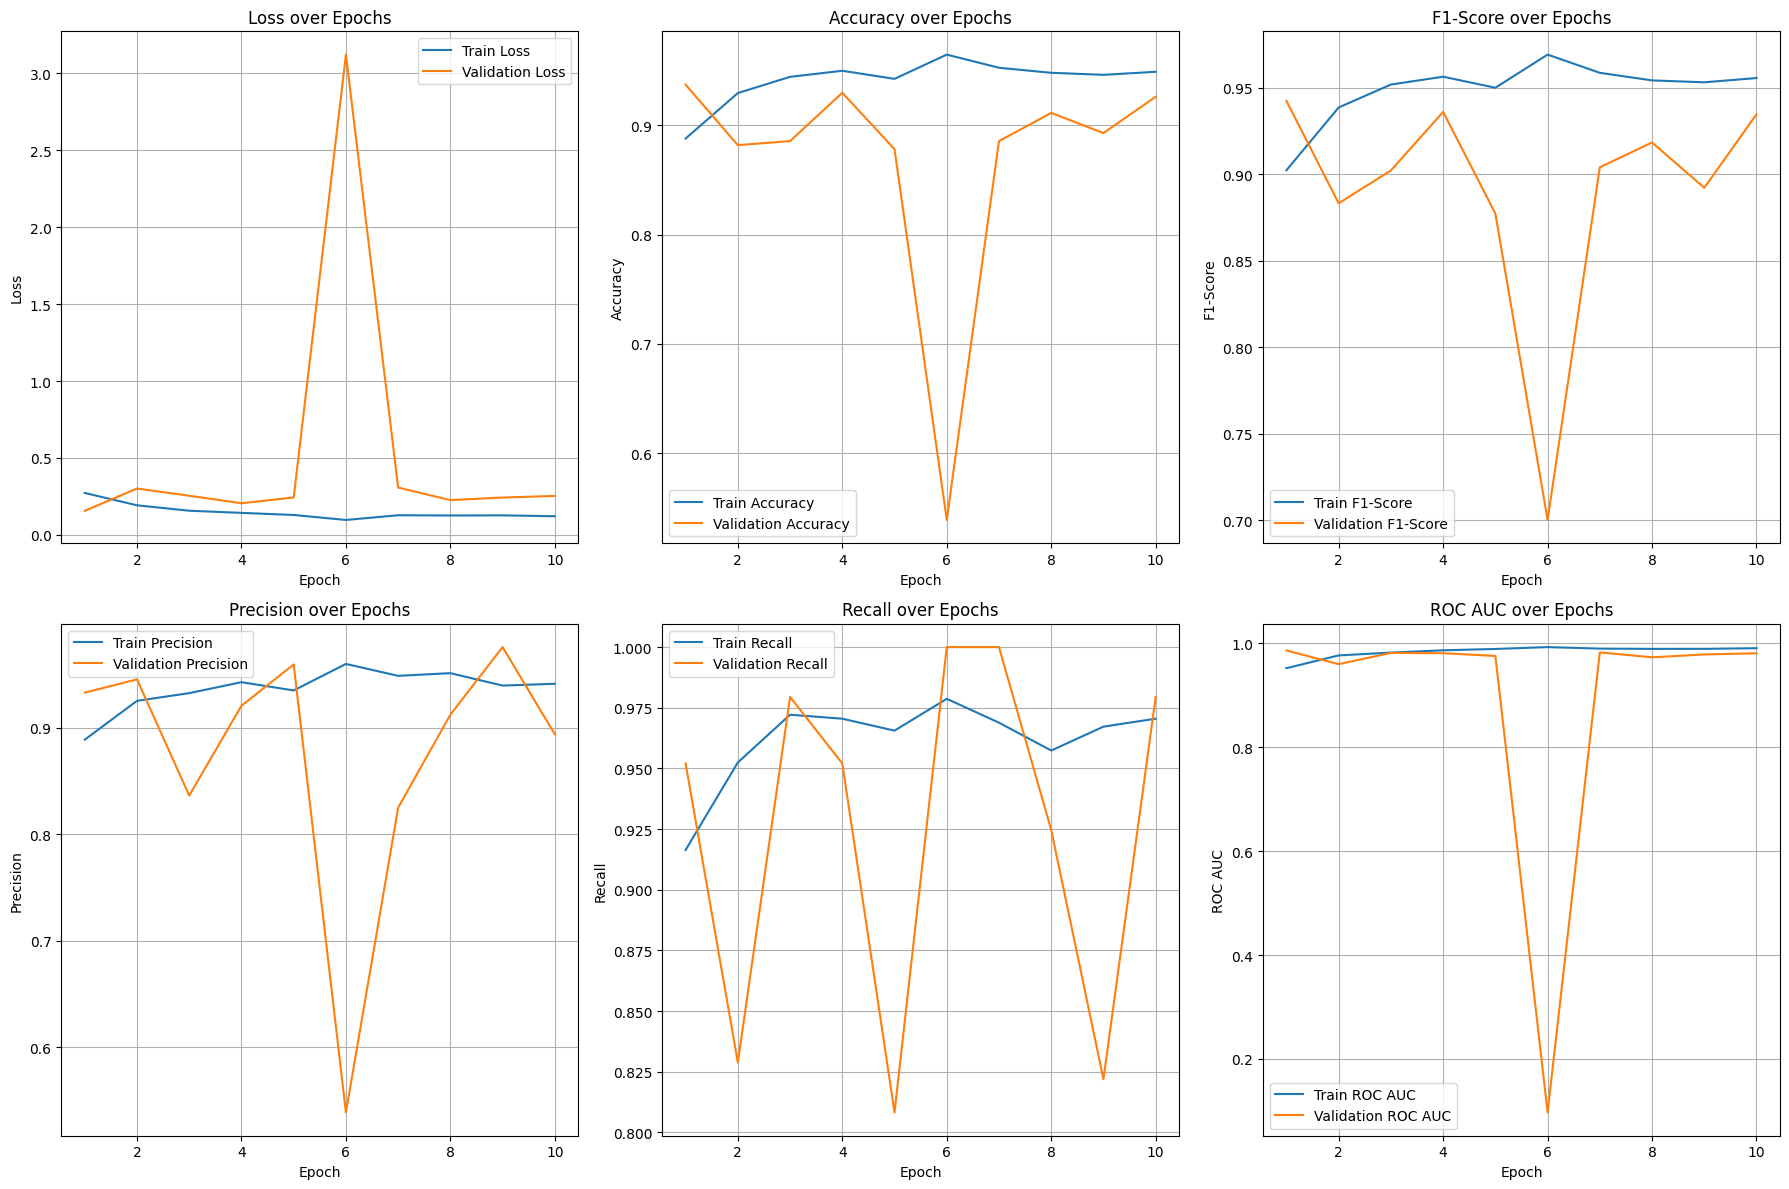


--- Final Classification Metrics (Validation Set) ---
   Metric    Value
 Accuracy 0.926199
 F1-Score 0.934641
Precision 0.893750
   Recall 0.979452
  ROC AUC 0.980986

--- Confusion Matrix (Validation Set) ---


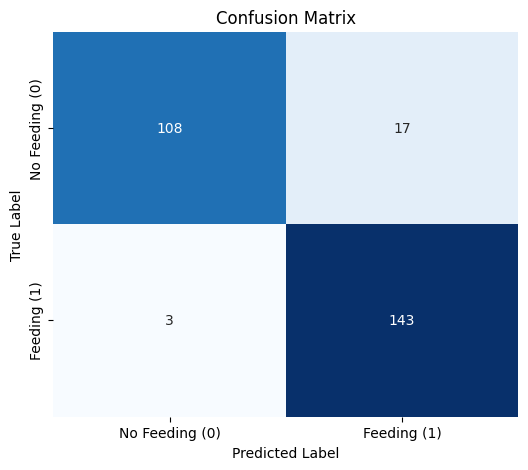


--- Visualizing Classification Predictions and Grad-CAM ---


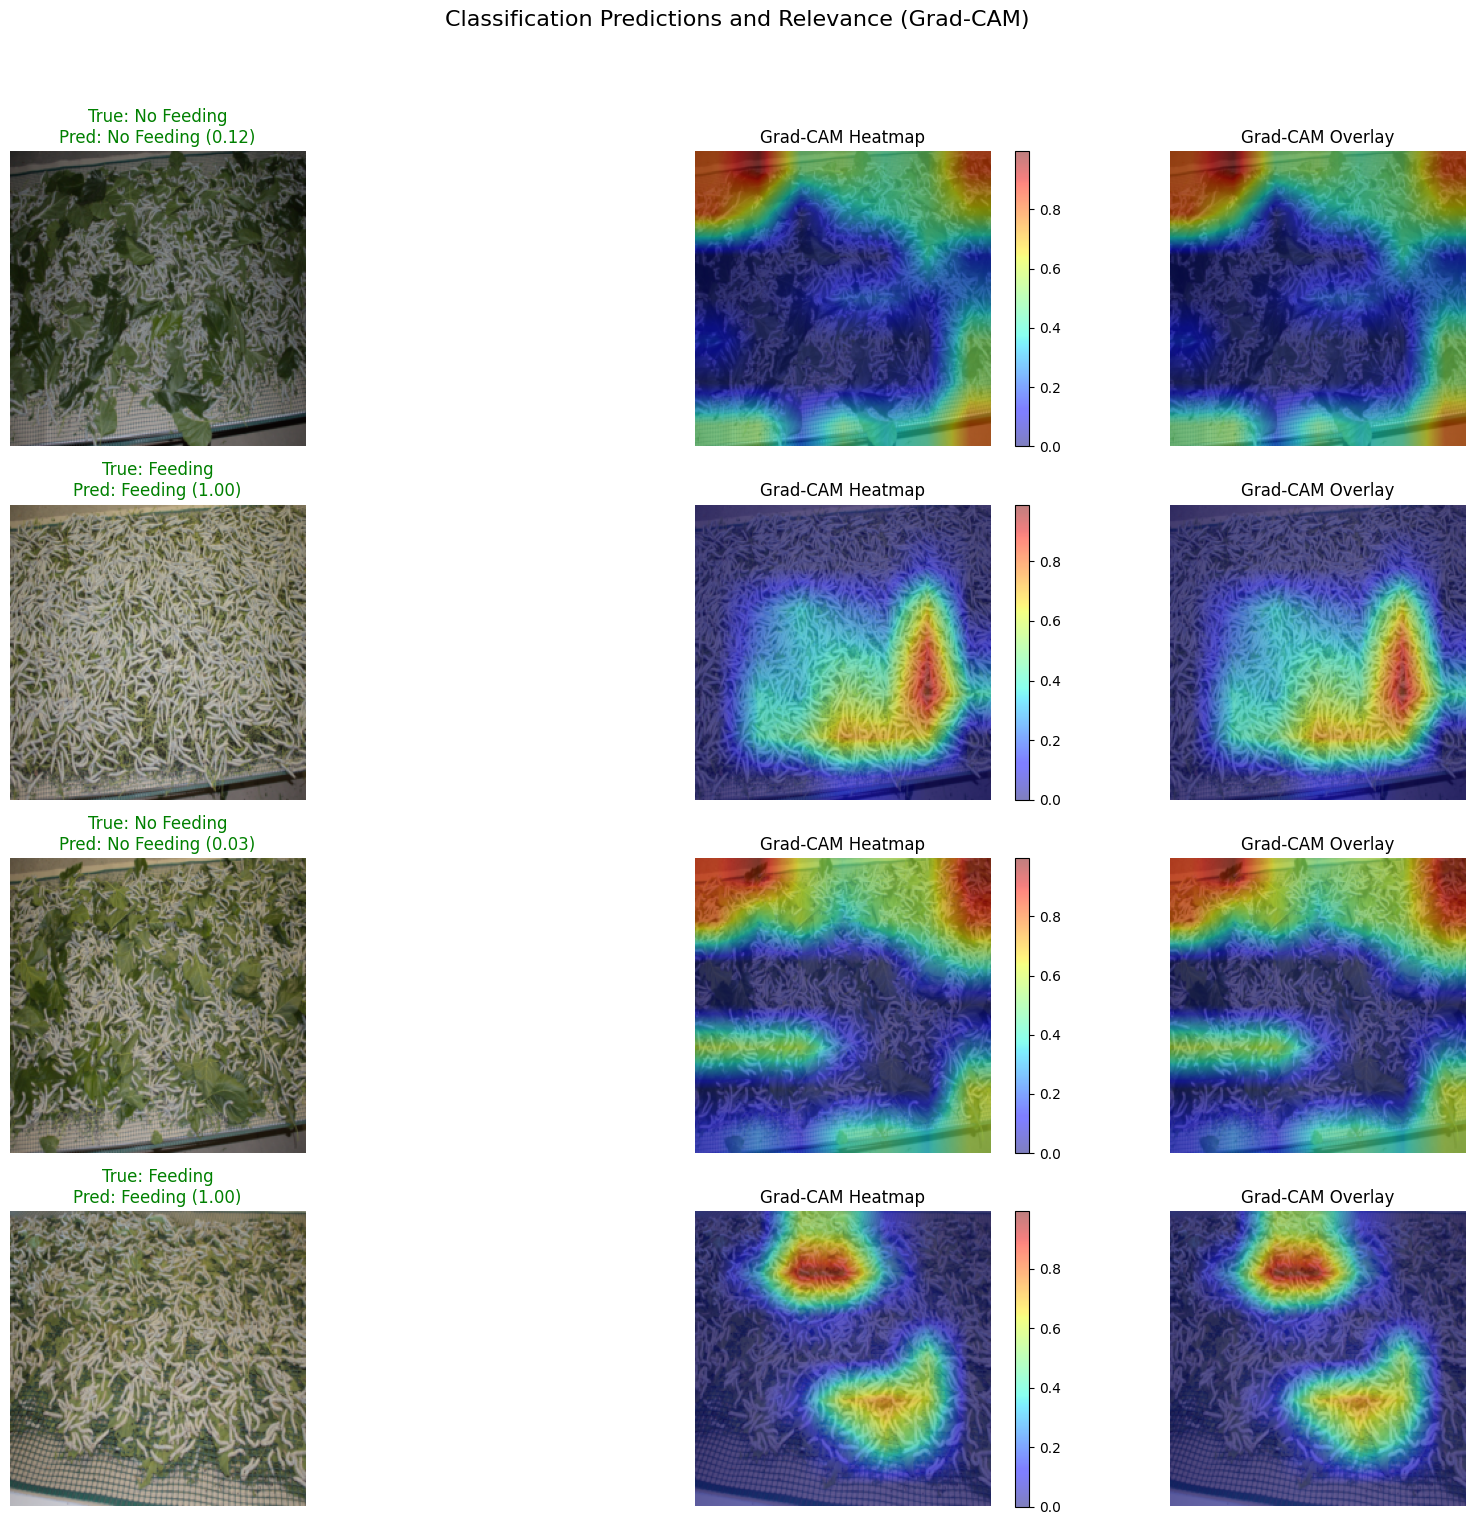

In [6]:
# --- Plotting Training History ---
print("\n--- Plotting Training and Validation Metrics ---")
epochs = range(1, NUM_CLASSIFICATION_EPOCHS + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(epochs, history['train_f1'], label='Train F1-Score')
plt.plot(epochs, history['val_f1'], label='Validation F1-Score')
plt.title('F1-Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(epochs, history['train_precision'], label='Train Precision')
plt.plot(epochs, history['val_precision'], label='Validation Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(epochs, history['train_recall'], label='Train Recall')
plt.plot(epochs, history['val_recall'], label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(epochs, history['train_roc_auc'], label='Train ROC AUC')
plt.plot(epochs, history['val_roc_auc'], label='Validation ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Classification Metrics Table ---
print("\n--- Final Classification Metrics (Validation Set) ---")
final_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC AUC'],
    'Value': [
        history['val_acc'][-1],
        history['val_f1'][-1],
        history['val_precision'][-1],
        history['val_recall'][-1],
        history['val_roc_auc'][-1]
    ]
})
print(final_metrics.to_string(index=False))

# --- Confusion Matrix ---
print("\n--- Confusion Matrix (Validation Set) ---")
conf_matrix = confusion_matrix(val_labels, val_preds_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Feeding (0)', 'Feeding (1)'],
            yticklabels=['No Feeding (0)', 'Feeding (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# --- Visualize Classification Predictions with Grad-CAM ---
print("\n--- Visualizing Classification Predictions and Grad-CAM ---")

def visualize_classification_predictions_with_cam(model, data_loader, device, num_samples=8):
    """
    Visualizes original images along with their true labels, model predictions, and Grad-CAM heatmaps.
    """
    model.eval()
    images_display = []
    true_labels_display = []
    predicted_probs_display = []
    heatmaps_display = []

    # Determine target layer for Grad-CAM
    grad_cam_target_layer_name = None
    if CLASSIFICATION_MODEL_TYPE == 'efficientnet_v2_s':
        # Inspect model.features. It usually has blocks 0 to 7. The last one is features.7
        # Or, you can loop model.named_modules() to find it
        # For EfficientNetV2-S, 'features.6' or 'features.7' are good candidates
        # Let's use 'features.6' as it's typically the last large spatial feature map producer.
        grad_cam_target_layer_name = 'features.6' # <--- UPDATED FOR EFFICIENTNETV2-S
    elif CLASSIFICATION_MODEL_TYPE == 'mobilevit_s':
        grad_cam_target_layer_name = 'final_conv.conv'
    elif CLASSIFICATION_MODEL_TYPE == 'repnext_m1':
        grad_cam_target_layer_name = 'stages.3.blocks.1.token_mixer.conv_s.conv_3_3'  # Check RepNext architecture for proper conv layer


    try:
        grad_cam_extractor = GradCAM(model, grad_cam_target_layer_name)
    except ValueError as e:
        print(f"Error creating GradCAM extractor: {e}. Skipping Grad-CAM visualization.")
        return

    with torch.no_grad(): # Initial forward pass without gradients for collecting images/labels
        for images, labels in data_loader:
            # Denormalize images for display
            denorm_images = images.cpu().numpy().transpose((0, 2, 3, 1))
            denorm_images = denorm_images * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
            denorm_images = np.clip(denorm_images, 0, 1)

            for i in range(min(images.shape[0], num_samples - len(images_display))):
                images_display.append(denorm_images[i])
                true_labels_display.append(labels[i].item())

                input_tensor_for_cam = images[i].unsqueeze(0).to(device)

                # Enable grad for torch for CAM calculation
                with torch.enable_grad():
                    output_logit = model(input_tensor_for_cam)
                    predicted_prob = torch.sigmoid(output_logit).item()
                    predicted_probs_display.append(predicted_prob)

                    heatmap = grad_cam_extractor(input_tensor_for_cam)
                    heatmaps_display.append(heatmap)

            if len(images_display) >= num_samples:
                break

    if not images_display:
        print("No images to visualize for classification predictions.")
        return

    plt.figure(figsize=(18, 4 * len(images_display)))
    plt.suptitle("Classification Predictions and Relevance (Grad-CAM)", fontsize=16)

    for i in range(len(images_display)):
        # Column 1: Original Image + Prediction
        plt.subplot(len(images_display), 3, i * 3 + 1)
        plt.imshow(images_display[i])

        true_label_text = "Feeding" if true_labels_display[i] == 1 else "No Feeding"
        predicted_class = "Feeding" if predicted_probs_display[i] > 0.5 else "No Feeding"

        title_color = "green" if (predicted_probs_display[i] > 0.5 and true_labels_display[i] == 1) or \
                                 (predicted_probs_display[i] <= 0.5 and true_labels_display[i] == 0) else "red"

        plt.title(f"True: {true_label_text}\nPred: {predicted_class} ({predicted_probs_display[i]:.2f})", color=title_color)
        plt.axis('off')

        # Column 2: Grad-CAM Heatmap
        plt.subplot(len(images_display), 3, i * 3 + 2)
        plt.imshow(images_display[i]) # Overlay on original image
        # cv2.resize wants (width, height)
        plt.imshow(cv2.resize(heatmaps_display[i], (IMAGE_SIZE[1], IMAGE_SIZE[0])), cmap='jet', alpha=0.5)
        plt.title("Grad-CAM Heatmap")
        plt.axis('off')
        plt.colorbar(ax=plt.gca(), fraction=0.046, pad=0.04)

        # Column 3: Grad-CAM Overlay
        plt.subplot(len(images_display), 3, i * 3 + 3)
        plt.imshow(images_display[i])
        plt.imshow(cv2.resize(heatmaps_display[i], (IMAGE_SIZE[1], IMAGE_SIZE[0])), cmap='jet', alpha=0.5)
        plt.title("Grad-CAM Overlay")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

visualize_classification_predictions_with_cam(classification_model, val_loader, device, num_samples=4) # Reduced to 4 for clarity


In [ ]:
OUTPUT_SEGMENTATION_DIR = "/kaggle/working/unsupervised_segmentation_output_dinov2_clustering/" # Directory to save output segmentation masks.

os.makedirs(OUTPUT_SEGMENTATION_DIR, exist_ok=True) # Create the output directory if it doesn't exist.

YOUR_IMAGES_SOURCE_DIR = '/kaggle/input/silk-dataset/silk_dataset' # Source directory of your raw images.


# --- Unsupervised Segmentation of Rearing Beds ---
print("\n--- Starting Unsupervised Segmentation Task (DINO Features + Clustering) ---")

# --- 1. Loading DINOv2 Model for Feature Extraction ---
print("\nLoading DINOv2 model for feature extraction...")
try:
    model_type_dinov2 = "dinov2_vitb14" # Specifies the DINOv2 Vision Transformer model type (Base/14).
    # Load the DINOv2 model from PyTorch Hub.
    dino_feature_extractor = torch.hub.load('facebookresearch/dinov2', model_type_dinov2)
    dino_feature_extractor.eval().to(device) # Set the model to evaluation mode and move it to the specified device (GPU/CPU).
    print(f"DINOv2 model '{model_type_dinov2}' loaded successfully.")

except Exception as e:
    print(f"CRITICAL ERROR: Failed to load DINOv2 model: {e}")
    print("Please ensure you have an active internet connection or that the model is already downloaded in PyTorch's cache.")
    print("If you receive errors, try installing 'timm' or check your connection: !pip install timm")
    import sys
    sys.exit("Cannot proceed without the feature extraction model.") # Exit the script if the model cannot be loaded.

# --- Clustering Parameter: desired number of segments. 
NUM_SEGMENTATION_CLASSES_DINO = 3 #3 classes (e.g., silkworms, leaves, background). This is 'K' for KMeans.
print(f"DINO clustering will look for {NUM_SEGMENTATION_CLASSES_DINO} segments.")

# --- 2. Image Processing: DINO Feature Extraction and Clustering ---
print("\nStarting image processing (DINO Feature Extraction + Clustering)...")
print("This process might take time depending on dataset size and GPU availability.")

# Variables for statistics and visualization.
processed_count_dino_clustering = 0
skipped_count_dino_clustering = 0
example_images_dino_clustering = [] # To store some original image examples for display.
example_masks_dino_clustering = []  # To store corresponding segmented mask examples.
max_examples_to_show = 5  # Maximum number of examples to show in the display grid.
all_cluster_labels_flat = [] # To collect all cluster labels for distribution analysis.

start_time = time.time() # Record the start time of the process.

# Create a dataset and DataLoader specifically for feature extraction.
feature_extract_dataset_dino = SilkwormDataset(dataframe=df, root_dir=YOUR_IMAGES_SOURCE_DIR, transform=val_transforms)
feature_loader_dino = DataLoader(feature_extract_dataset_dino, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

all_features_list_dino = [] # List to collect DINO features from all images.
all_image_feature_map_shapes_dino = [] # To store (H_feat, W_feat) for each image's feature map.

print("Extracting DINO features for clustering...")
with torch.no_grad(): # Disable gradient calculations for efficiency during feature extraction.
    for images, _ in tqdm(feature_loader_dino, desc="DINO Feature Extraction"): # Iterate through images in the DataLoader.
        images = images.to(device) # Move images to the specified device.
        # Extract features from the DINOv2 model. 'x_norm_patchtokens' gives normalized patch embeddings.
        features = dino_feature_extractor.forward_features(images)['x_norm_patchtokens'] # Output: [batch_size, N_patches, D]

        if features.dim() != 3: # DINOv2 patch tokens should be 3D: [Batch, Number_of_patches, Feature_Dimension].
            raise RuntimeError(f"Feature extractor output is {features.dim()}D. Expected 3D patch tokens (Batch, N_patches, Dim) for clustering.")

        # Reshape features for clustering: Flatten the patch dimension to [batch_size * N_patches, Feature_Dimension].
        # Calculate the height and width of the feature map (number of patches in each dimension).
        H_feat = IMAGE_SIZE[0] // dino_feature_extractor.patch_size # Image height divided by patch size.
        W_feat = IMAGE_SIZE[1] // dino_feature_extractor.patch_size # Image width divided by patch size.
        
        # Store feature map shapes for later reconstruction of segmentation masks.
        for k in range(features.shape[0]): # Iterate through the batch.
            all_image_feature_map_shapes_dino.append((H_feat, W_feat))

        features_flat = features.reshape(-1, features.shape[2]).cpu().numpy() # Flatten and move to CPU, convert to NumPy array.
        all_features_list_dino.append(features_flat) # Add flattened features to the list.

all_features_np_dino = np.vstack(all_features_list_dino) # Vertically stack all collected features into a single NumPy array.
print(f"Total DINO features extracted: {all_features_np_dino.shape} (pixels x feature_dimension)")

# Apply StandardScaler to normalize the features. This is important for KMeans.
scaler_dino = StandardScaler()
features_for_clustering_dino = scaler_dino.fit_transform(all_features_np_dino) # Fit and transform the features.

# Apply MiniBatchKMeans clustering.
print(f"Applying MiniBatchKMeans with {NUM_SEGMENTATION_CLASSES_DINO} clusters...")
kmeans_dino = MiniBatchKMeans(n_clusters=NUM_SEGMENTATION_CLASSES_DINO, random_state=42, n_init=10, init='k-means++')
kmeans_dino.fit(features_for_clustering_dino) # Fit KMeans to the scaled features.
all_cluster_labels_flat.extend(kmeans_dino.labels_) # Collect all assigned cluster labels for analysis.

# --- Generating Masks and Selecting Examples ---
print("\nGenerating masks and saving examples...")

num_total_images = len(df) # Total number of images in the dataset.
# Randomly select indices of images to display as examples.
indices_to_show = random.sample(range(num_total_images), k=min(max_examples_to_show, num_total_images))
print(f"Random indices selected for visualization: {indices_to_show}")
examples_to_plot = {} # Dictionary to store original images and their segmented masks for selected examples.

current_pixel_idx_dino = 0 # Counter to keep track of the current position in the flattened array of cluster labels.
image_file_list = df['file_name'].tolist() # Get the list of image filenames from the DataFrame.

for i, img_name in enumerate(tqdm(image_file_list, desc="Saving Masks")): # Iterate through each image to generate and save its mask.
    try:
        # Construct the full path where the segmented mask will be saved.
        output_segmentation_path_dino = os.path.join(
            OUTPUT_SEGMENTATION_DIR,
            f"segmented_dinov2_{os.path.splitext(img_name)[0]}.png" # Naming convention for the output mask.
        )
        
        img_path = os.path.join(YOUR_IMAGES_SOURCE_DIR, img_name) # Full path to the original image.
        original_image_size = Image.open(img_path).size # Get the original dimensions of the image.
        H_feat, W_feat = all_image_feature_map_shapes_dino[i] # Get the feature map dimensions for the current image.
        
        num_pixels_in_feature_map = H_feat * W_feat # Total number of patches (pixels) in the feature map.
        # Extract the cluster labels corresponding to the current image from the overall flattened labels.
        single_image_cluster_map_flat = kmeans_dino.labels_[current_pixel_idx_dino : current_pixel_idx_dino + num_pixels_in_feature_map]
        current_pixel_idx_dino += num_pixels_in_feature_map # Advance the counter for the next image.
        
        cluster_map_raw = single_image_cluster_map_flat.reshape(H_feat, W_feat) # Reshape the flattened labels back to a 2D map.
        # Resize the raw cluster map to the original image's resolution using nearest-neighbor interpolation
        # to preserve integer class labels.
        segmentation_map_full_res = cv2.resize(
            cluster_map_raw.astype(np.uint8), # Ensure the map is uint8.
            original_image_size, # Target size.
            interpolation=cv2.INTER_NEAREST # Crucial for masks to avoid interpolating labels.
        )
        
        # Save the generated segmentation mask as a PNG image.
        Image.fromarray(segmentation_map_full_res).save(output_segmentation_path_dino)

        if i in indices_to_show: # If the current image is one of the selected examples for visualization.
            original_img = Image.open(img_path).convert("RGB") # Load the original image.
            examples_to_plot[i] = (original_img, segmentation_map_full_res) # Store it with its segmented mask.

    except Exception as e:
        print(f"Error during processing of {img_name}: {e}")
        continue # Continue to the next image even if an error occurs.

# --- Preparation for Visualization ---
# Collect the original images and their corresponding segmented masks for plotting.
example_images_dino_clustering = []
example_masks_dino_clustering = []
sorted_indices = sorted(examples_to_plot.keys()) # Sort the indices to display examples in a consistent order.
for index in sorted_indices:
    img, mask = examples_to_plot[index]
    example_images_dino_clustering.append(img)
    example_masks_dino_clustering.append(mask)

# --- Visualization of Generated Examples ---
print("\n--- Random Segmentation Examples ---")
if example_images_dino_clustering: # Proceed only if there are examples to display.
    num_examples = len(example_images_dino_clustering) # Number of examples to plot.
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 5)) # Create a subplot grid.
    if num_examples == 1: # Adjust axes indexing if only one example.
        axes = np.expand_dims(axes, axis=0)

    for i in range(num_examples):
        # Subplot 1: Original Image
        axes[i, 0].imshow(example_images_dino_clustering[i])
        axes[i, 0].set_title(f'Original (Random Index: {sorted_indices[i]})') # Title with original image index.
        axes[i, 0].axis('off') # Turn off axes.

        # Normalize original image for overlay plotting (0.0-1.0 range).
        original_image_np = np.array(example_images_dino_clustering[i]) / 255.0
        # Apply a colormap (e.g., 'tab10' for distinct categories) to the segmentation mask.
        # Normalize mask values to the colormap range (0 to 1).
        mask_color_map = plt.colormaps['tab10'](example_masks_dino_clustering[i] / (NUM_SEGMENTATION_CLASSES_DINO - 1))
        mask_color_map[..., 3] = 0.5 # Set alpha (transparency) for the mask overlay.

        # Subplot 2: DINO Segmentation Overlay
        axes[i, 1].imshow(original_image_np) # Display original image as background.
        axes[i, 1].imshow(mask_color_map) # Overlay the colored segmentation mask.
        axes[i, 1].set_title(f'DINO Segmentation (K={NUM_SEGMENTATION_CLASSES_DINO})') # Title for segmented image.
        axes[i, 1].axis('off')
    
    plt.tight_layout() # Adjust subplot parameters for a tight layout.
    plt.show() # Display the plots.
else:
    print("No examples to visualize.")
    
# --- Plotting Cluster Distribution ---
print("\n--- Pixel Distribution per Cluster (DINO + Clustering) ---")
if all_cluster_labels_flat: # Proceed only if cluster labels were collected.
    plt.figure(figsize=(8, 6)) # Create a figure for the histogram.
    # Plot a histogram of cluster label distribution.
    plt.hist(all_cluster_labels_flat, bins=np.arange(-0.5, NUM_SEGMENTATION_CLASSES_DINO + 0.5, 1), edgecolor='black', rwidth=0.8)
    plt.xticks(range(NUM_SEGMENTATION_CLASSES_DINO)) # Set x-ticks to be the cluster IDs.
    plt.title('Pixel Distribution within Clusters') # Title of the plot.
    plt.xlabel('Cluster ID') # X-axis label.
    plt.ylabel('Number of Pixels') # Y-axis label.
    plt.grid(axis='y', alpha=0.75) # Add a grid for readability.
    plt.show() # Display the histogram.
else:
    print("No cluster data available to visualize distribution.")
print("\n--- End of DINO (Clustering) Mask Generation Code ---")




In [ ]:
# --- Configuration Parameters ---
KAGGLE_DATA_PATH = '/kaggle/input/silk-dataset/'  # Base path for your dataset on Kaggle.
YOUR_IMAGES_SOURCE_DIR = os.path.join(KAGGLE_DATA_PATH, 'silk_dataset') # Path to your original images.

# --- Define Output Directories for Each Segmentation Method ---
# These paths point to where the masks generated by different methods are stored.
DINO_KMEANS_OUTPUT_DIR = "/kaggle/working/unsupervised_segmentation_output_dinov2_clustering/"
SAM_OUTPUT_DIR = '/kaggle/input/masks-generated/sam_generated_masks/kaggle/working/sam_generated_masks'
KMEANS_LAB_OUTPUT_DIR = "/kaggle/input/kmeans/kmeans_generated_masks-4"
WATERSHED_OUTPUT_DIR = "/kaggle/input/masks-generated/watershed_generated_masks"
SEGFORMER_MANUAL_OUTPUT_DIR = "/kaggle/input/labelmemask/kaggle/working/segformer_inference_results_mini_dataset"

# --- Define the image(s) you want to visualize ---
# List of image filenames (e.g., "IMG_XXXX.jpg") to load and compare segmentation results for.
IMAGES_TO_COMPARE = [
    "IMG_3200.jpg",
]

# --- Define Class IDs and Color Map ---
# Mapping of class names to integer IDs used in the masks.
CLASS_TO_ID = { "background": 0, "leaf": 1, "silk": 2, "unknown": 3 }

# Custom Colors for Visualization (RGBA format: Red, Green, Blue, Alpha).
# Alpha channel controls transparency (0.0 is fully transparent, 1.0 is fully opaque).
vis_custom_colors = [
    [0.0, 0.0, 0.0, 0.0],  # ID 0: Background (Transparent, often used for underlying image)
    [0.0, 1.0, 0.0, 0.5],  # ID 1: Leaf (Green, semi-transparent overlay)
    [1.0, 0.5, 0.0, 0.6],  # ID 2: Silk (Orange, slightly more opaque overlay)
    [0.5, 0.5, 0.5, 0.4]   # ID 3: Unknown (Gray, semi-transparent overlay)
]
vis_custom_cmap = mcolors.ListedColormap(vis_custom_colors) # Create a Matplotlib colormap from the custom colors.

# Class Labels for the Legend.
# This dictionary maps integer IDs to human-readable names for display in the plot legend.
CLASS_LABELS_FOR_LEGEND = { 0: "Background", 1: "Leaf", 2: "Silk", 3: "Unknown" }

# --- List of Methods to Compare ---
# A dictionary mapping method names (for display) to their respective mask output directories.
SEGMENTATION_METHODS = {
    "Original": YOUR_IMAGES_SOURCE_DIR, # The original image itself (no mask overlay).
    "DINO+KMeans": DINO_KMEANS_OUTPUT_DIR,
    "SAM": SAM_OUTPUT_DIR,
    "KMeans+LAB": KMEANS_LAB_OUTPUT_DIR,
    "Watershed": WATERSHED_OUTPUT_DIR,
    "SegFormer": SEGFORMER_MANUAL_OUTPUT_DIR
}

# --- Function to Load and Overlay Mask ---
def load_and_overlay_mask(original_img_np: np.ndarray, mask_path: str, method_name: str, original_filename_stem: str) -> np.ndarray:
    """
    Loads a segmentation mask generated by a specific method, applies a custom colormap,
    and overlays it onto the original image. Handles different mask naming conventions
    and data formats based on the segmentation method.

    Args:
        original_img_np (np.ndarray): The original image as a NumPy array (RGB, 0-255).
        mask_path (str): The base directory where the masks for this method are stored.
        method_name (str): The name of the segmentation method (e.g., "DINO+KMeans", "Watershed").
        original_filename_stem (str): The filename stem of the original image (e.g., "IMG_3200").

    Returns:
        np.ndarray: The original image with the colored mask overlayed, or just the original
                    image if the mask cannot be loaded/processed or for the "Original" method.
    """
    try:
        if method_name == "Original":
            return original_img_np # For "Original" method, just return the raw image.

        # --- SPECIAL HANDLING FOR WATERSHED MASKS ---
        # Watershed masks might be saved as RGB images where colors represent classes,
        # unlike other methods that save grayscale label maps.
        if method_name == "Watershed":
            mask_filename = f"{original_filename_stem}_watershed_mask.png" # Specific naming for Watershed masks.
            full_mask_path = os.path.join(mask_path, mask_filename)
            if not os.path.exists(full_mask_path):
                print(f"Warning: Mask not found for {method_name}: {full_mask_path}.")
                return original_img_np # Return original if mask is missing.

            # 1. Load the mask as a color image (RGB).
            mask_rgb = np.array(Image.open(full_mask_path).convert('RGB'))
            
            # 2. Create a transparent RGBA mask of the same dimensions.
            h, w, _ = mask_rgb.shape
            colored_mask_rgba = np.zeros((h, w, 4), dtype=np.float32) # Initialize with transparent black.

            # 3. Manually map the specific RGB colors in the Watershed mask to visualization colors.
            # Map GREEN pixels from the Watershed mask to the visualization's semi-transparent green.
            leaf_mask_pixels = (mask_rgb[:, :, 1] > 200) & (mask_rgb[:, :, 0] < 50) & (mask_rgb[:, :, 2] < 50)
            colored_mask_rgba[leaf_mask_pixels] = [0.0, 1.0, 0.0, 0.5] # Green, semi-transparent (Leaf ID 1).
            
            # Map RED pixels from the Watershed mask to the visualization's semi-transparent orange (for consistency with "Silk").
            worm_mask_pixels = (mask_rgb[:, :, 0] > 200) & (mask_rgb[:, :, 1] < 50) & (mask_rgb[:, :, 2] < 50)
            colored_mask_rgba[worm_mask_pixels] = [1.0, 0.5, 0.0, 0.6] # Orange, semi-transparent (Silk ID 2).
            
            # Other pixels (e.g., background or unclassified) remain transparent due to initialization.

        # --- STANDARD HANDLING FOR ALL OTHER METHODS ---
        # These methods are assumed to output single-channel (L-mode) PNGs where pixel values are class IDs.
        else:
            # Determine the specific mask filename based on the method's naming convention.
            if method_name == "DINO+KMeans":
                mask_filename = f"segmented_dinov2_{original_filename_stem}.png"
            elif method_name == "SAM":
                mask_filename = f"sam_{original_filename_stem}.png"
            elif method_name == "KMeans+LAB":
                mask_filename = f"kmeans_multiclass_{original_filename_stem}.png"
            elif method_name == "SegFormer":
                mask_filename = f"{original_filename_stem}_segformer_pred.png"
            else:
                return original_img_np # Return original image if the method name is not recognized.

            full_mask_path = os.path.join(mask_path, mask_filename)
            if not os.path.exists(full_mask_path):
                print(f"Warning: Mask not found for {method_name}: {full_mask_path}.")
                return original_img_np # Return original image if mask is missing.
            
            # Load the label mask (grayscale image where pixel values are class IDs).
            mask_image_pil = Image.open(full_mask_path)
            # Ensure the mask is in 'L' mode (8-bit pixels, grayscale) for label maps.
            if mask_image_pil.mode != 'L':
                mask_image_pil = mask_image_pil.convert('L')
            mask_np = np.array(mask_image_pil) # Convert PIL image to NumPy array.
            
            # Apply the standard custom colormap (vis_custom_cmap) to convert label IDs to RGBA colors.
            colored_mask_rgba = vis_custom_cmap(mask_np)

        # --- COMMON OVERLAY LOGIC ---
        # This part applies to both Watershed (after manual color mapping) and other methods.

        # Resize the colored mask to match the original image's dimensions if they differ.
        if colored_mask_rgba.shape[:2] != original_img_np.shape[:2]:
            colored_mask_rgba = cv2.resize(
                colored_mask_rgba, 
                (original_img_np.shape[1], original_img_np.shape[0]), 
                interpolation=cv2.INTER_NEAREST # Use nearest-neighbor to maintain sharp mask edges and avoid interpolation artifacts on colors.
            )

        # Prepare original image for blending: normalize to 0.0-1.0 float and add an opaque alpha channel.
        img_float = original_img_np.astype(np.float32) / 255.0
        img_rgba = np.concatenate([img_float, np.ones_like(img_float[..., :1])], axis=-1)
        
        alpha = colored_mask_rgba[..., 3:4] # Extract the alpha channel from the colored mask.
        # Blend the original image and the colored mask using their alpha channels.
        # blended_img = (1 - alpha) * original_image + alpha * colored_mask_rgba
        blended_img = (1 - alpha) * img_rgba + alpha * colored_mask_rgba
        
        # Convert the blended image back to 0-255 uint8 format.
        return (blended_img * 255).astype(np.uint8)

    except Exception as e:
        print(f"Error processing {method_name} mask '{full_mask_path if 'full_mask_path' in locals() else 'N/A'}': {e}")
        return original_img_np # Return the original image if an error occurs during processing.


# --- Main Visualization Loop ---
print("\n" + "="*80 + "\n          COMPARING SEGMENTATION METHODS\n" + "="*80)

for img_filename in IMAGES_TO_COMPARE: # Iterate through each image specified for comparison.
    print(f"\n--- Processing Image: {img_filename} ---")
    
    original_image_path = os.path.join(YOUR_IMAGES_SOURCE_DIR, img_filename) # Full path to the original image.
    original_image_np = np.array(Image.open(original_image_path).convert('RGB')) # Load original image as RGB NumPy array.
    original_filename_stem = os.path.splitext(img_filename)[0] # Extract the filename without extension.

    num_methods = len(SEGMENTATION_METHODS) # Get the total number of segmentation methods to compare.
    fig, axes = plt.subplots(1, num_methods, figsize=(4 * num_methods, 5)) # Create a figure with subplots (1 row, N methods).
    if num_methods == 1: # Adjust axes indexing if only one method is being displayed.
        axes = [axes]

    # Iterate through each segmentation method and its corresponding mask directory.
    for i, (method_name, mask_base_dir) in enumerate(SEGMENTATION_METHODS.items()):
        # Load and overlay the mask for the current method.
        processed_img_for_display = load_and_overlay_mask(original_image_np, mask_base_dir, method_name, original_filename_stem)
        axes[i].imshow(processed_img_for_display) # Display the processed image.
        axes[i].set_title(f"{method_name}") # Set the title for the subplot (method name).
        axes[i].axis('off') # Turn off axes.

    # Create legend handles for the custom class colors.
    handles = [mpatches.Patch(color=vis_custom_colors[i], label=label) 
               for i, label in CLASS_LABELS_FOR_LEGEND.items()]
    # Add a single legend to the right of the entire figure.
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.02, 0.5))
    
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to prevent overlap, leaving space for the legend.
    plt.show() # Display the comparison plot for the current image.

print("\n--- Comparison Visualization Complete ---")